In [39]:
import pandas as pd
import glob 
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
import seaborn as sns

save_path = 'Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [9]:

summary_df = pd.read_csv("../Logs/Summary.csv")

planners = ['GlobalPlanPP', "FollowTheGap", "EndToEnd"]
test_ids = ["mu70", "Std", "TestTD3"]

results_df = summary_df.loc[summary_df.Vehicle.isin(planners)]
results_df = results_df.loc[results_df.TestID.isin(test_ids)]

times_df = results_df.pivot(index="Vehicle", columns="MapName", values="AvgTime")
times_df.columns = times_df.columns.str.upper()
print(times_df)

times_df.to_latex(f"{save_path}benchmark_laptimes.tex", float_format="%.2f")


MapName           AUT      ESP    GBR     MCO
Vehicle                                      
EndToEnd      31.4267  78.0667  64.76  59.030
FollowTheGap  19.0300  45.7440  39.32  35.016
GlobalPlanPP  18.6640  39.2160  33.92  30.552


In [21]:


map_name = "esp"
lap_n = 1

planners = ['GlobalPlanPP', "FollowTheGap", "EndToEnd"]
test_ids = ["mu70", "Std", "TestTD3"]

table_data = []
dfs = []
for i in range(3):
    data = np.load(f"../Logs/{planners[i]}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    dfs.append(df)

    el_lengths = np.linalg.norm(np.diff(data[:, :2], axis=0), axis=1)
    psi, kappa = tph.calc_head_curv_num.calc_head_curv_num(data[:, :2], el_lengths, False)
    mean_curvature = np.mean(np.abs(kappa))

    steer_diffs = df.steer_a.diff().abs()
    mean_steering_change = steer_diffs.mean()

    mean_slip_angle = df.slip.abs().mean()
    max_slip_angle = df.slip.abs().max()

    results = {"planner": f"{planners[i]}",
                "mean_curvature": mean_curvature,
                "mean_steering_change": mean_steering_change,
                "mean_slip_anlge": mean_slip_angle,
                "max_slip_anlge": max_slip_angle}
    table_data.append(results)

df = pd.DataFrame(table_data)
print(df)




        planner  mean_curvature  mean_steering_change  mean_slip_anlge  \
0  GlobalPlanPP        0.147159              0.010456         0.040854   
1  FollowTheGap        0.115529              0.008111         0.025248   
2      EndToEnd        0.522761              0.122072         0.028473   

   max_slip_anlge  
0        0.138003  
1        0.313287  
2        0.150474  


In [34]:
map_name = "esp"
n_laps = 5

planners = ['GlobalPlanPP', "FollowTheGap", "EndToEnd"]
neat_planner_names = ["Pure pursuit", "Follow the gap", "End-to-end"]
test_ids = ["mu70", "Std", "TestTD3"]

table_data = []
dfs = []
for i in range(3):
    for lap_n in range(n_laps):
        data = np.load(f"../Logs/{planners[i]}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
        df.steer_a = df.steer_a * 180 / np.pi
        df.yaw = df.yaw * 180 / np.pi
        df.slip = df.slip * 180 / np.pi
        dfs.append(df)

        el_lengths = np.linalg.norm(np.diff(data[:, :2], axis=0), axis=1)
        psi, kappa = tph.calc_head_curv_num.calc_head_curv_num(data[:, :2], el_lengths, False)
        mean_curvature = np.mean(np.abs(kappa)) * 180 / np.pi # degrees per m 

        steer_diffs = df.steer_a.diff()
        steer_dd = df.steer_a.diff().diff()
        mean_steering_change = steer_diffs.abs().mean()
        mean_steer_dd = steer_dd.abs().mean()

        mean_slip_angle = df.slip.abs().mean()
        max_slip_angle = df.slip.abs().max()

        results = {"planner": f"{neat_planner_names[i]}",
                    # "lap_n": lap_n,
                    "Curvature": mean_curvature,
                    "Action jerkiness": mean_steering_change,
                    # "mean_steer_dd": mean_steer_dd,
                    "Mean slip": mean_slip_angle,
                    "Max slip": max_slip_angle}
        table_data.append(results)

df = pd.DataFrame(table_data)
# print(df)

mean_df = df.groupby("planner").mean()
print(mean_df)

times_df.to_latex(f"{save_path}mean_{map_name}_stats.tex", float_format="%.2f")

std_df = df.groupby("planner").std()
print(std_df)




                Curvature  Action jerkiness  Mean slip   Max slip
planner                                                          
End-to-end      29.554220          6.988369   1.615046   8.643679
Follow the gap   6.889177          0.468875   1.422953  17.349928
Pure pursuit     8.320166          0.597212   2.318851   8.008203
                Curvature  Action jerkiness  Mean slip  Max slip
planner                                                         
End-to-end       0.596137          0.184805   0.098854  3.172773
Follow the gap   0.254440          0.006523   0.018583  0.797670
Pure pursuit     0.071968          0.015457   0.033472  0.281830


Pure pursuit      2.340741
Follow the gap    1.446612
End-to-end        1.631364
dtype: float64


Text(0, 0.5, 'Frequency [%]')

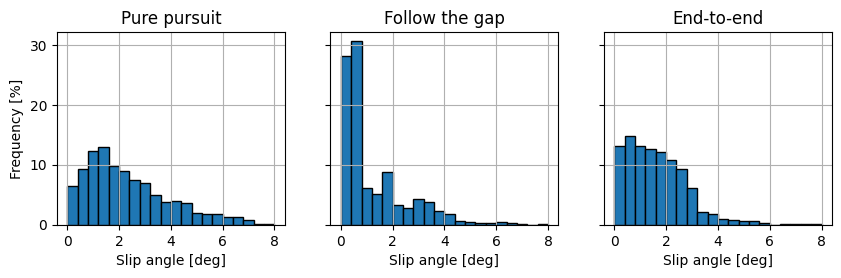

In [85]:
map_name = "esp"
lap_n = 1
from matplotlib.ticker import PercentFormatter

planners = ['GlobalPlanPP', "FollowTheGap", "EndToEnd"]
test_ids = ["mu70", "Std", "TestTD3"]

dfs = []
for i in range(3):
    data = np.load(f"../Logs/{planners[i]}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df.slip = df.slip * 180 / np.pi
    df = df.slip.abs()
    dfs.append(df)

df = pd.concat(dfs, axis=1)
df.columns = neat_planner_names
print(df.mean())

# df.boxplot()
# axs = df.hist(bins=20, sharex=True, layout=(1, 3), figsize=(10, 2.5), sharey=True, range=(0, 8))
# print(axs)
# for i, ax in enumerate(axs.flatten()):
#     print(ax)
#     print(len(dfs[i]))
#     ax.yaxis.set_major_formatter(PercentFormatter(xmax=len(dfs[i])))

# plt.grid(True)

fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), sharey=True)
for i in range(3):
    plt.sca(axs[i])
    hist, edges = np.histogram(dfs[i], bins=20, range=(0, 8))
    freq = hist / float(hist.sum()) * 100
    width = np.diff(edges) # edges is bins
    plt.bar(edges[:-1], freq, width=width, align="edge", ec="k")
    plt.xlabel("Slip angle [deg]")
    plt.title(neat_planner_names[i])
    plt.grid(True)

axs[0].set_ylabel("Frequency [%]")


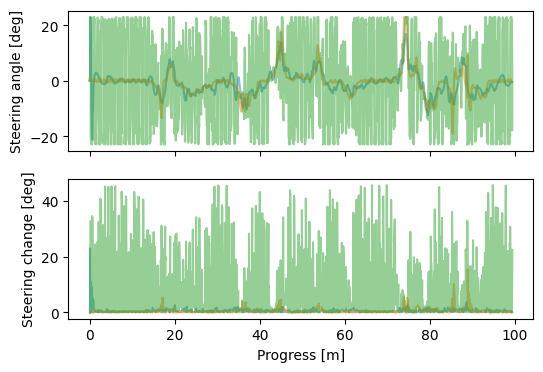

In [90]:
map_name = "esp"
lap_n = 1
from matplotlib.ticker import PercentFormatter

planners = ['GlobalPlanPP', "FollowTheGap", "EndToEnd"]
test_ids = ["mu70", "Std", "TestTD3"]

dfs = []
for i in range(3):
    data = np.load(f"../Logs/{planners[i]}/RawData_{test_ids[i]}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df.steer_a = df.steer_a * 180 / np.pi
    df.progress = df.progress * 100
    df = df[["steer_a", "progress"]]
    df["d_steer"] = df.steer_a.diff().abs()
    dfs.append(df)

# df = pd.concat(dfs, axis=1)
# df.columns = neat_planner_names

# df_d = df.diff().abs()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax1.set_ylabel("Steering angle [deg]")
ax2.set_xlabel("Progress [m]")
ax2.set_ylabel("Steering change [deg]")

for i in range(3):
    df = dfs[i]
    ax1.plot(df["progress"], df["steer_a"], label=neat_planner_names[i], alpha=0.5)

    ax2.plot(df["progress"], df["d_steer"], label=neat_planner_names[i], alpha=0.5)
